In [257]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append('..')

from data_loading import apply_preprocessing

In [334]:
data_fp = '../solodoch_data_minimal/26N.nc'
ecco_data = xr.open_dataset(data_fp)

rapid_fp = '../RAPID/moc_transports.nc'
rapid_data = xr.open_dataset(rapid_fp)
rapid_data = rapid_data['moc_mar_hc10'].resample(time = 'MS').mean().to_dataset()
rapid_data['moc_mar_hc10'] = ['time', 'latitude'], rapid_data['moc_mar_hc10'].values.reshape(rapid_data['moc_mar_hc10'].shape[0], -1)
rapid_data = rapid_data.assign_coords(latitude = np.atleast_1d(26))

In [314]:
prepprocessed = apply_preprocessing(ecco_data, 'inputs', 
                                    standardize = True, 
                                    remove_season = True, 
                                    remove_trend = True, 
                                    lowpass = False)
prepprocessed

<xarray.Dataset>
Dimensions:    (time: 288, latitude: 1, longitude: 164)
Coordinates:
  * latitude   (latitude) float32 26.25
  * longitude  (longitude) float32 -96.75 -96.25 -95.75 ... -15.25 -14.75 -14.25
  * time       (time) datetime64[ns] 1992-01-16T18:00:00 ... 2015-12-16T12:00:00
Data variables:
    SSH        (time, latitude, longitude) float64 1.501 1.501 ... -0.3345
    ZWS        (time, latitude, longitude) float64 -0.1901 -0.1901 ... -0.1145
    OBP        (time, latitude, longitude) float64 1.639 1.639 ... -1.247 -1.247
    SSS        (time, latitude, longitude) float64 -0.1207 -0.1207 ... 2.419
    SST        (time, latitude, longitude) float64 -0.3329 -0.3329 ... -0.828

-2.7755575615628914e-17
0.9999999999999998


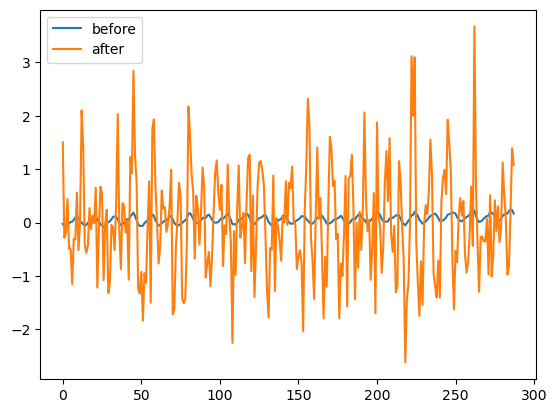

In [316]:
var = 'SSH'
lon = 0

var_of_interest = prepprocessed[var].values.squeeze()
before_processing = ecco_data[var].values.squeeze()

print(var_of_interest[ : , lon].mean())
print(var_of_interest[ : , lon].std())

plt.plot(before_processing[ : , lon], label = 'before')
plt.plot(var_of_interest[ : , lon], label = 'after')
plt.legend()

In [347]:
moc_preprocessed = apply_preprocessing(rapid_data, 'outputs', 
                                       standardize = False, 
                                       remove_season = True, 
                                       remove_trend = False, 
                                       lowpass = False)
moc_preprocessed

<xarray.Dataset>
Dimensions:       (time: 215, latitude: 1)
Coordinates:
  * time          (time) datetime64[ns] 2004-04-01 2004-05-01 ... 2022-02-01
  * latitude      (latitude) int64 26
Data variables:
    moc_mar_hc10  (time, latitude) float64 19.58 17.1 13.42 ... 14.5 10.4 11.62

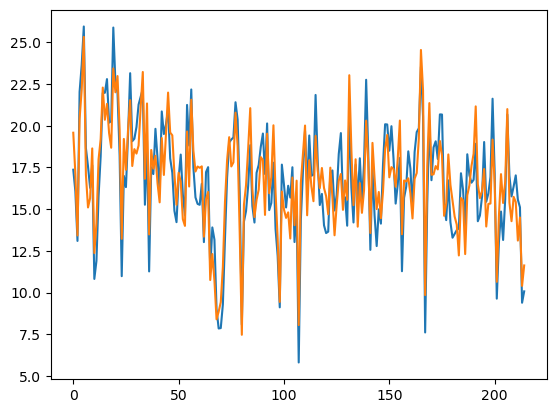

In [348]:
plt.plot(rapid_data['moc_mar_hc10'])
plt.plot(moc_preprocessed['moc_mar_hc10'])